In [1]:
from pathlib import Path

ROOT = Path("/Users/kamilkhaidir/Documents/UTM/SEM2/Adv AI/project2")

# Sub-folders expected by the dataset spec
TRAIN_DIR = ROOT / "train"
VAL_DIR   = ROOT / "validation"
TEST_DIR  = ROOT / "test"

for p in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    assert p.exists(), f"Folder not found: {p}"
print("All three splits located ✔️")


All three splits located ✔️


In [2]:
import pandas as pd
from collections import Counter
from tqdm import tqdm

def count_images(split_dir: Path) -> pd.DataFrame:
    rows = []
    for class_dir in tqdm(sorted(split_dir.iterdir()), desc=f"Scanning {split_dir.name}"):
        if class_dir.is_dir():
            n_images = len(list(class_dir.glob("*.jpg")))   # adjust extension if needed
            rows.append({"class": class_dir.name, "n": n_images})
    return pd.DataFrame(rows)

train_counts = count_images(TRAIN_DIR)
val_counts   = count_images(VAL_DIR)
test_counts  = count_images(TEST_DIR)

summary = pd.DataFrame({
    "train": train_counts.set_index("class")["n"],
    "val":   val_counts.set_index("class")["n"],
    "test":  test_counts.set_index("class")["n"],
}).sort_index()

summary.head()     # show first few rows
print("\nTotal images per split:", summary.sum().to_dict())

Scanning test: 100%|██████████████████████████| 37/37 [00:00<00:00, 1089.17it/s]


Total images per split: {'train': 2780, 'val': 334, 'test': 334}


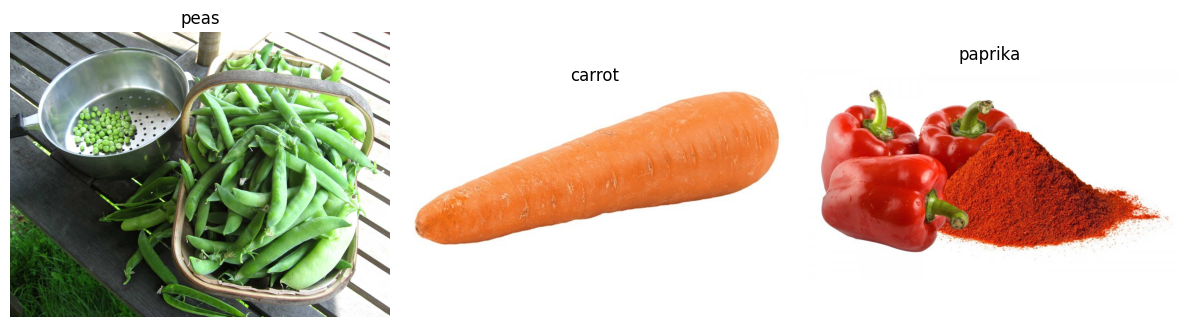

In [3]:
#sanity check on the images
import random
import matplotlib.pyplot as plt
from PIL import Image

def show_random_images(split_dir, n=3):
    class_dirs = [d for d in split_dir.iterdir() if d.is_dir()]
    samples = []
    for _ in range(n):
        cdir = random.choice(class_dirs)
        img_path = random.choice(list(cdir.glob("*.jpg")))
        samples.append((cdir.name, img_path))

    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    for ax, (cls, path) in zip(axes, samples):
        ax.imshow(Image.open(path))
        ax.set_title(cls)
        ax.axis("off")
    plt.tight_layout()

show_random_images(TRAIN_DIR, n=3)


In [4]:
#save the count
summary.to_csv("class_counts.csv", index=True)
print("➜ Saved to class_counts.csv")

➜ Saved to class_counts.csv


In [5]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Resize Image and define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Train/Validation/Test splits
train_ds = image_dataset_from_directory(
    TRAIN_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'  
)

val_ds = image_dataset_from_directory(
    VAL_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_ds = image_dataset_from_directory(
    TEST_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names) 

# Preprocessing (normalizes pixels to [-1, 1])
def preprocess(img, label):
    return preprocess_input(img), label

train_ds = train_ds.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds  = test_ds.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)


2025-06-30 22:45:51.975526: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.
Found 359 files belonging to 36 classes.


In [22]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

IMG_SHAPE = IMG_SIZE + (3,)  # (224, 224, 3)

# Load base MobileNetV2 
base_model = MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,           
    weights="imagenet"           
)
base_model.trainable = False    

# Build new classifier 
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),           # flatten into 1D
    layers.Dropout(0.2),                       
    layers.Dense(NUM_CLASSES, activation='softmax')  # output = 36 classes
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks - to save the best model and avoid overfitting
checkpoint_cb = ModelCheckpoint(
    "best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max'
)

earlystop_cb = EarlyStopping(
    patience=5, restore_best_weights=True, monitor='val_accuracy', mode='max'
)

In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │        46,116 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,304,100 (8.79 MB)

 Trainable params: 46,116 (180.14 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[checkpoint_cb, earlystop_cb]
)
if earlystop_cb.stopped_epoch > 0:
    print(f"Training stopped early at epoch {earlystop_cb.stopped_epoch + 1}")
    print(f"Best model was from epoch {earlystop_cb.best_epoch + 1}")
else:
    print("Training completed all epochs without early stopping.")

Epoch 1/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 13:47 9s/step - accuracy: 0.0625 - loss: 4.2498

2025-06-30 22:46:17.113214: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:46:17.127553: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/98 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - accuracy: 0.0469 - loss: 4.2023 

2025-06-30 22:46:17.550448: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:46:18.019153: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/98 ━━━━━━━━━━━━━━━━━━━━ 1:55 1s/step - accuracy: 0.0388 - loss: 4.1389

2025-06-30 22:46:22.165270: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/98 ━━━━━━━━━━━━━━━━━━━━ 1:46 1s/step - accuracy: 0.0417 - loss: 4.0784

2025-06-30 22:46:24.609582: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/98 ━━━━━━━━━━━━━━━━━━━━ 1:44 1s/step - accuracy: 0.0428 - loss: 4.0486

2025-06-30 22:46:24.888902: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


11/98 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 0.0480 - loss: 3.9914

2025-06-30 22:46:27.382806: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:46:27.726363: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/98 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.0501 - loss: 3.9661

2025-06-30 22:46:28.365977: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/98 ━━━━━━━━━━━━━━━━━━━━ 1:29 1s/step - accuracy: 0.0627 - loss: 3.8533

2025-06-30 22:46:33.354253: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


18/98 ━━━━━━━━━━━━━━━━━━━━ 1:27 1s/step - accuracy: 0.0656 - loss: 3.8316

2025-06-30 22:46:34.385647: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/98 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - accuracy: 0.0821 - loss: 3.7279

2025-06-30 22:46:39.316376: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


27/98 ━━━━━━━━━━━━━━━━━━━━ 1:15 1s/step - accuracy: 0.0959 - loss: 3.6499

2025-06-30 22:46:43.464963: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


29/98 ━━━━━━━━━━━━━━━━━━━━ 1:13 1s/step - accuracy: 0.1034 - loss: 3.6114

2025-06-30 22:46:45.706452: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


34/98 ━━━━━━━━━━━━━━━━━━━━ 1:08 1s/step - accuracy: 0.1228 - loss: 3.5172

2025-06-30 22:46:51.094350: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


48/98 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.1771 - loss: 3.2786

2025-06-30 22:47:05.147036: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


52/98 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.1912 - loss: 3.2182

2025-06-30 22:47:09.078961: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


65/98 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2320 - loss: 3.0435

2025-06-30 22:47:21.807317: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:47:21.828010: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


75/98 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.2600 - loss: 2.9261

2025-06-30 22:47:32.642907: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


78/98 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2680 - loss: 2.8930

2025-06-30 22:47:35.657888: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


79/98 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.2707 - loss: 2.8822

2025-06-30 22:47:36.873748: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3152 - loss: 2.6985

2025-06-30 22:47:57.757183: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:47:57.898972: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.3173 - loss: 2.6900 - val_accuracy: 0.8547 - val_loss: 0.5936
Epoch 2/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - accuracy: 0.8438 - loss: 0.6467

2025-06-30 22:48:10.414378: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/98 ━━━━━━━━━━━━━━━━━━━━ 2:07 1s/step - accuracy: 0.8516 - loss: 0.6499

2025-06-30 22:48:11.141101: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:48:11.325083: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/98 ━━━━━━━━━━━━━━━━━━━━ 1:54 1s/step - accuracy: 0.8524 - loss: 0.6592

2025-06-30 22:48:11.929750: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/98 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.8452 - loss: 0.6905

2025-06-30 22:48:15.331047: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/98 ━━━━━━━━━━━━━━━━━━━━ 1:49 1s/step - accuracy: 0.8372 - loss: 0.7069

2025-06-30 22:48:15.574026: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:48:16.476177: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/98 ━━━━━━━━━━━━━━━━━━━━ 1:49 1s/step - accuracy: 0.8330 - loss: 0.7109

2025-06-30 22:48:17.244903: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/98 ━━━━━━━━━━━━━━━━━━━━ 1:47 1s/step - accuracy: 0.8304 - loss: 0.7136

2025-06-30 22:48:17.813700: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/98 ━━━━━━━━━━━━━━━━━━━━ 1:31 1s/step - accuracy: 0.8266 - loss: 0.7106

2025-06-30 22:48:28.701439: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/98 ━━━━━━━━━━━━━━━━━━━━ 1:24 1s/step - accuracy: 0.8264 - loss: 0.7069

2025-06-30 22:48:34.399385: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:48:34.470938: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/98 ━━━━━━━━━━━━━━━━━━━━ 1:21 1s/step - accuracy: 0.8254 - loss: 0.7073

2025-06-30 22:48:36.378432: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


33/98 ━━━━━━━━━━━━━━━━━━━━ 1:10 1s/step - accuracy: 0.8229 - loss: 0.7082

2025-06-30 22:48:44.433113: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:48:44.470928: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


36/98 ━━━━━━━━━━━━━━━━━━━━ 1:07 1s/step - accuracy: 0.8220 - loss: 0.7083

2025-06-30 22:48:47.839846: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:48:47.912895: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


42/98 ━━━━━━━━━━━━━━━━━━━━ 1:00 1s/step - accuracy: 0.8206 - loss: 0.7084

2025-06-30 22:48:54.320610: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


46/98 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8195 - loss: 0.7086

2025-06-30 22:48:58.898634: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


65/98 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8143 - loss: 0.7094

2025-06-30 22:49:18.874093: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


67/98 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8140 - loss: 0.7092

2025-06-30 22:49:21.221015: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


70/98 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8136 - loss: 0.7089

2025-06-30 22:49:24.589158: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


74/98 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8130 - loss: 0.7083

2025-06-30 22:49:28.689473: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8116 - loss: 0.7031

2025-06-30 22:49:51.873619: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:49:59.049996: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.8116 - loss: 0.7028 - val_accuracy: 0.9003 - val_loss: 0.3715
Epoch 3/30


2025-06-30 22:50:06.058600: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/98 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - accuracy: 0.9062 - loss: 0.5519

2025-06-30 22:50:08.489756: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/98 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - accuracy: 0.8984 - loss: 0.5313

2025-06-30 22:50:09.222338: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/98 ━━━━━━━━━━━━━━━━━━━━ 2:17 1s/step - accuracy: 0.8976 - loss: 0.5230

2025-06-30 22:50:11.115980: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/98 ━━━━━━━━━━━━━━━━━━━━ 1:58 1s/step - accuracy: 0.9006 - loss: 0.5005

2025-06-30 22:50:13.901751: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/98 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.9006 - loss: 0.4883

2025-06-30 22:50:17.082272: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/98 ━━━━━━━━━━━━━━━━━━━━ 1:46 1s/step - accuracy: 0.8992 - loss: 0.4845

2025-06-30 22:50:21.217501: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


13/98 ━━━━━━━━━━━━━━━━━━━━ 1:45 1s/step - accuracy: 0.8992 - loss: 0.4829

2025-06-30 22:50:22.351818: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/98 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.8974 - loss: 0.4827

2025-06-30 22:50:26.962928: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


18/98 ━━━━━━━━━━━━━━━━━━━━ 1:36 1s/step - accuracy: 0.8967 - loss: 0.4830

2025-06-30 22:50:28.283359: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


19/98 ━━━━━━━━━━━━━━━━━━━━ 1:35 1s/step - accuracy: 0.8961 - loss: 0.4829

2025-06-30 22:50:29.079608: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


24/98 ━━━━━━━━━━━━━━━━━━━━ 1:27 1s/step - accuracy: 0.8928 - loss: 0.4835

2025-06-30 22:50:34.805597: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


29/98 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - accuracy: 0.8906 - loss: 0.4835

2025-06-30 22:50:40.188917: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:50:40.432327: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


33/98 ━━━━━━━━━━━━━━━━━━━━ 1:15 1s/step - accuracy: 0.8896 - loss: 0.4821

2025-06-30 22:50:44.637908: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


37/98 ━━━━━━━━━━━━━━━━━━━━ 1:10 1s/step - accuracy: 0.8888 - loss: 0.4811

2025-06-30 22:50:48.815975: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


47/98 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8877 - loss: 0.4793

2025-06-30 22:50:59.278650: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


49/98 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8874 - loss: 0.4791

2025-06-30 22:51:01.595369: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


51/98 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8870 - loss: 0.4793

2025-06-30 22:51:03.669767: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


62/98 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8849 - loss: 0.4810

2025-06-30 22:51:15.310098: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


69/98 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8838 - loss: 0.4811

2025-06-30 22:51:23.042300: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


70/98 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8837 - loss: 0.4811

2025-06-30 22:51:23.971245: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


78/98 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8824 - loss: 0.4815

2025-06-30 22:51:32.668828: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8801 - loss: 0.4809

2025-06-30 22:51:53.556418: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:51:58.553839: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.8801 - loss: 0.4809 - val_accuracy: 0.9316 - val_loss: 0.2919
Epoch 4/30
 3/98 ━━━━━━━━━━━━━━━━━━━━ 1:53 1s/step - accuracy: 0.9115 - loss: 0.3167

2025-06-30 22:52:10.498526: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/98 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.9162 - loss: 0.3042

2025-06-30 22:52:13.533098: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/98 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.9155 - loss: 0.3060

2025-06-30 22:52:14.940828: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/98 ━━━━━━━━━━━━━━━━━━━━ 1:49 1s/step - accuracy: 0.9154 - loss: 0.3068

2025-06-30 22:52:15.683643: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:52:15.975844: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:52:16.482409: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/98 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.9143 - loss: 0.3101

2025-06-30 22:52:17.358926: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


11/98 ━━━━━━━━━━━━━━━━━━━━ 1:53 1s/step - accuracy: 0.9086 - loss: 0.3237

2025-06-30 22:52:21.621048: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


13/98 ━━━━━━━━━━━━━━━━━━━━ 1:52 1s/step - accuracy: 0.9069 - loss: 0.3295

2025-06-30 22:52:24.661011: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/98 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.9067 - loss: 0.3315

2025-06-30 22:52:25.892106: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


19/98 ━━━━━━━━━━━━━━━━━━━━ 1:41 1s/step - accuracy: 0.9052 - loss: 0.3403

2025-06-30 22:52:31.446805: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:52:31.557799: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:52:31.579323: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/98 ━━━━━━━━━━━━━━━━━━━━ 1:36 1s/step - accuracy: 0.9050 - loss: 0.3425

2025-06-30 22:52:35.050066: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


29/98 ━━━━━━━━━━━━━━━━━━━━ 1:24 1s/step - accuracy: 0.9041 - loss: 0.3480

2025-06-30 22:52:42.601036: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


35/98 ━━━━━━━━━━━━━━━━━━━━ 1:15 1s/step - accuracy: 0.9039 - loss: 0.3501

2025-06-30 22:52:48.847029: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


41/98 ━━━━━━━━━━━━━━━━━━━━ 1:07 1s/step - accuracy: 0.9033 - loss: 0.3525

2025-06-30 22:52:55.517902: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


52/98 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9022 - loss: 0.3567

2025-06-30 22:53:07.467722: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


61/98 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9012 - loss: 0.3600

2025-06-30 22:53:18.116371: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


64/98 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9009 - loss: 0.3608

2025-06-30 22:53:21.682572: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


65/98 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9009 - loss: 0.3610

2025-06-30 22:53:22.800568: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


68/98 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9006 - loss: 0.3618

2025-06-30 22:53:25.954485: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


77/98 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9001 - loss: 0.3635

2025-06-30 22:53:35.618150: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9000 - loss: 0.3658

2025-06-30 22:54:02.385137: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:54:04.333596: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.9000 - loss: 0.3658 - val_accuracy: 0.9459 - val_loss: 0.2499
Epoch 5/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - accuracy: 0.9375 - loss: 0.1952

2025-06-30 22:54:14.692006: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/98 ━━━━━━━━━━━━━━━━━━━━ 1:52 1s/step - accuracy: 0.9375 - loss: 0.2061

2025-06-30 22:54:15.897507: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/98 ━━━━━━━━━━━━━━━━━━━━ 1:57 1s/step - accuracy: 0.9135 - loss: 0.2756

2025-06-30 22:54:21.157361: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:54:21.316243: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/98 ━━━━━━━━━━━━━━━━━━━━ 1:57 1s/step - accuracy: 0.9142 - loss: 0.2790

2025-06-30 22:54:24.012551: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/98 ━━━━━━━━━━━━━━━━━━━━ 1:55 1s/step - accuracy: 0.9146 - loss: 0.2818

2025-06-30 22:54:25.873432: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/98 ━━━━━━━━━━━━━━━━━━━━ 1:54 1s/step - accuracy: 0.9157 - loss: 0.2838

2025-06-30 22:54:31.462906: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/98 ━━━━━━━━━━━━━━━━━━━━ 1:53 1s/step - accuracy: 0.9154 - loss: 0.2847

2025-06-30 22:54:35.121279: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:54:35.428743: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:54:35.676906: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/98 ━━━━━━━━━━━━━━━━━━━━ 1:52 1s/step - accuracy: 0.9153 - loss: 0.2855

2025-06-30 22:54:36.241647: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


19/98 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.9156 - loss: 0.2862

2025-06-30 22:54:39.084290: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


24/98 ━━━━━━━━━━━━━━━━━━━━ 1:41 1s/step - accuracy: 0.9157 - loss: 0.2906

2025-06-30 22:54:45.643158: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


26/98 ━━━━━━━━━━━━━━━━━━━━ 1:37 1s/step - accuracy: 0.9160 - loss: 0.2915

2025-06-30 22:54:47.985736: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


32/98 ━━━━━━━━━━━━━━━━━━━━ 1:27 1s/step - accuracy: 0.9167 - loss: 0.2936

2025-06-30 22:54:54.945015: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


33/98 ━━━━━━━━━━━━━━━━━━━━ 1:25 1s/step - accuracy: 0.9168 - loss: 0.2938

2025-06-30 22:54:56.266073: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


34/98 ━━━━━━━━━━━━━━━━━━━━ 1:24 1s/step - accuracy: 0.9169 - loss: 0.2939

2025-06-30 22:54:57.310073: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


48/98 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - accuracy: 0.9158 - loss: 0.2984

2025-06-30 22:55:14.346393: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


50/98 ━━━━━━━━━━━━━━━━━━━━ 1:01 1s/step - accuracy: 0.9157 - loss: 0.2987

2025-06-30 22:55:16.946811: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


61/98 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9151 - loss: 0.3012

2025-06-30 22:55:29.129208: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


65/98 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9148 - loss: 0.3020

2025-06-30 22:55:33.717838: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


80/98 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9147 - loss: 0.3031

2025-06-30 22:55:53.025547: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:55:53.394638: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9149 - loss: 0.3035

2025-06-30 22:56:12.008407: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:56:16.996254: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.9149 - loss: 0.3035 - val_accuracy: 0.9544 - val_loss: 0.2189
Epoch 6/30
 2/98 ━━━━━━━━━━━━━━━━━━━━ 1:57 1s/step - accuracy: 0.9062 - loss: 0.3006

2025-06-30 22:56:28.937147: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/98 ━━━━━━━━━━━━━━━━━━━━ 1:54 1s/step - accuracy: 0.9219 - loss: 0.2735

2025-06-30 22:56:31.772315: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:56:32.320220: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/98 ━━━━━━━━━━━━━━━━━━━━ 1:56 1s/step - accuracy: 0.9271 - loss: 0.2647

2025-06-30 22:56:35.017464: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/98 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.9325 - loss: 0.2597

2025-06-30 22:56:39.482724: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


11/98 ━━━━━━━━━━━━━━━━━━━━ 1:49 1s/step - accuracy: 0.9334 - loss: 0.2596

2025-06-30 22:56:40.381498: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/98 ━━━━━━━━━━━━━━━━━━━━ 1:49 1s/step - accuracy: 0.9342 - loss: 0.2589

2025-06-30 22:56:42.162837: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/98 ━━━━━━━━━━━━━━━━━━━━ 1:45 1s/step - accuracy: 0.9362 - loss: 0.2581

2025-06-30 22:56:45.693230: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


19/98 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.9373 - loss: 0.2579

2025-06-30 22:56:50.231539: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:56:50.712497: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/98 ━━━━━━━━━━━━━━━━━━━━ 1:33 1s/step - accuracy: 0.9380 - loss: 0.2580

2025-06-30 22:56:53.632045: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/98 ━━━━━━━━━━━━━━━━━━━━ 1:31 1s/step - accuracy: 0.9380 - loss: 0.2582

2025-06-30 22:56:54.770029: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


26/98 ━━━━━━━━━━━━━━━━━━━━ 1:26 1s/step - accuracy: 0.9382 - loss: 0.2582

2025-06-30 22:56:58.017526: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


28/98 ━━━━━━━━━━━━━━━━━━━━ 1:24 1s/step - accuracy: 0.9385 - loss: 0.2578

2025-06-30 22:57:00.393237: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


37/98 ━━━━━━━━━━━━━━━━━━━━ 1:11 1s/step - accuracy: 0.9390 - loss: 0.2557

2025-06-30 22:57:10.357532: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:57:10.538868: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


42/98 ━━━━━━━━━━━━━━━━━━━━ 1:05 1s/step - accuracy: 0.9388 - loss: 0.2558

2025-06-30 22:57:15.660910: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


43/98 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - accuracy: 0.9387 - loss: 0.2558

2025-06-30 22:57:17.230547: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


58/98 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9385 - loss: 0.2556

2025-06-30 22:57:34.941923: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


60/98 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9385 - loss: 0.2557

2025-06-30 22:57:37.079129: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


71/98 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9383 - loss: 0.2553

2025-06-30 22:57:48.835829: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


79/98 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9383 - loss: 0.2549

2025-06-30 22:57:58.427798: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


85/98 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9382 - loss: 0.2547

2025-06-30 22:58:06.098491: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9382 - loss: 0.2539

2025-06-30 22:58:21.547324: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:58:26.681585: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.9382 - loss: 0.2538 - val_accuracy: 0.9573 - val_loss: 0.2022
Epoch 7/30


2025-06-30 22:58:36.232156: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/98 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.9694 - loss: 0.1535

2025-06-30 22:58:45.758537: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:58:45.762058: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/98 ━━━━━━━━━━━━━━━━━━━━ 2:03 1s/step - accuracy: 0.9681 - loss: 0.1573

2025-06-30 22:58:46.447307: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/98 ━━━━━━━━━━━━━━━━━━━━ 2:02 1s/step - accuracy: 0.9657 - loss: 0.1613

2025-06-30 22:58:48.053267: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/98 ━━━━━━━━━━━━━━━━━━━━ 1:58 1s/step - accuracy: 0.9634 - loss: 0.1671

2025-06-30 22:58:51.303250: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


11/98 ━━━━━━━━━━━━━━━━━━━━ 1:57 1s/step - accuracy: 0.9628 - loss: 0.1687

2025-06-30 22:58:52.071124: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/98 ━━━━━━━━━━━━━━━━━━━━ 1:46 1s/step - accuracy: 0.9582 - loss: 0.1797

2025-06-30 22:58:59.561291: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 22:58:59.703711: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


18/98 ━━━━━━━━━━━━━━━━━━━━ 1:45 1s/step - accuracy: 0.9576 - loss: 0.1819

2025-06-30 22:59:00.851491: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/98 ━━━━━━━━━━━━━━━━━━━━ 1:42 1s/step - accuracy: 0.9563 - loss: 0.1858

2025-06-30 22:59:03.618205: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/98 ━━━━━━━━━━━━━━━━━━━━ 1:40 1s/step - accuracy: 0.9559 - loss: 0.1873

2025-06-30 22:59:04.761437: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/98 ━━━━━━━━━━━━━━━━━━━━ 1:36 1s/step - accuracy: 0.9548 - loss: 0.1906

2025-06-30 22:59:07.281461: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


24/98 ━━━━━━━━━━━━━━━━━━━━ 1:35 1s/step - accuracy: 0.9545 - loss: 0.1920

2025-06-30 22:59:08.010447: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


28/98 ━━━━━━━━━━━━━━━━━━━━ 1:28 1s/step - accuracy: 0.9534 - loss: 0.1961

2025-06-30 22:59:12.558499: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


31/98 ━━━━━━━━━━━━━━━━━━━━ 1:24 1s/step - accuracy: 0.9529 - loss: 0.1980

2025-06-30 22:59:16.169414: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/98 ━━━━━━━━━━━━━━━━━━━━ 1:06 1s/step - accuracy: 0.9512 - loss: 0.2032

2025-06-30 22:59:31.271715: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


48/98 ━━━━━━━━━━━━━━━━━━━━ 1:01 1s/step - accuracy: 0.9509 - loss: 0.2040

2025-06-30 22:59:35.939378: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


52/98 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9506 - loss: 0.2047

2025-06-30 22:59:40.545861: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


59/98 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9501 - loss: 0.2058

2025-06-30 22:59:48.854533: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


65/98 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9499 - loss: 0.2065

2025-06-30 22:59:55.551609: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


69/98 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9496 - loss: 0.2069

2025-06-30 22:59:59.505470: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


74/98 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9493 - loss: 0.2075

2025-06-30 23:00:04.772145: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9487 - loss: 0.2082

2025-06-30 23:00:29.932287: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:00:31.573624: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.9487 - loss: 0.2082 - val_accuracy: 0.9601 - val_loss: 0.1888
Epoch 8/30


2025-06-30 23:00:40.676946: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/98 ━━━━━━━━━━━━━━━━━━━━ 1:46 1s/step - accuracy: 0.9805 - loss: 0.1255

2025-06-30 23:00:46.288513: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/98 ━━━━━━━━━━━━━━━━━━━━ 1:52 1s/step - accuracy: 0.9738 - loss: 0.1405

2025-06-30 23:00:48.621695: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/98 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.9724 - loss: 0.1442

2025-06-30 23:00:50.314442: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/98 ━━━━━━━━━━━━━━━━━━━━ 1:48 1s/step - accuracy: 0.9705 - loss: 0.1479

2025-06-30 23:00:52.321645: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:00:52.385984: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/98 ━━━━━━━━━━━━━━━━━━━━ 1:56 1s/step - accuracy: 0.9692 - loss: 0.1500

2025-06-30 23:00:52.806237: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


11/98 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.9680 - loss: 0.1520

2025-06-30 23:00:55.468661: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/98 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.9674 - loss: 0.1528

2025-06-30 23:00:57.277214: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


13/98 ━━━━━━━━━━━━━━━━━━━━ 1:48 1s/step - accuracy: 0.9668 - loss: 0.1539

2025-06-30 23:00:58.300559: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:00:58.437497: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/98 ━━━━━━━━━━━━━━━━━━━━ 1:34 1s/step - accuracy: 0.9617 - loss: 0.1634

2025-06-30 23:01:05.529952: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/98 ━━━━━━━━━━━━━━━━━━━━ 1:33 1s/step - accuracy: 0.9613 - loss: 0.1644

2025-06-30 23:01:06.620489: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


27/98 ━━━━━━━━━━━━━━━━━━━━ 1:23 1s/step - accuracy: 0.9604 - loss: 0.1679

2025-06-30 23:01:13.157413: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


29/98 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - accuracy: 0.9602 - loss: 0.1688

2025-06-30 23:01:15.470444: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


30/98 ━━━━━━━━━━━━━━━━━━━━ 1:19 1s/step - accuracy: 0.9601 - loss: 0.1691

2025-06-30 23:01:16.470410: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


41/98 ━━━━━━━━━━━━━━━━━━━━ 1:05 1s/step - accuracy: 0.9598 - loss: 0.1733

2025-06-30 23:01:28.410228: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


51/98 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9598 - loss: 0.1754

2025-06-30 23:01:38.405783: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


55/98 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9598 - loss: 0.1759

2025-06-30 23:01:42.333892: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


58/98 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9599 - loss: 0.1762

2025-06-30 23:01:45.403476: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


61/98 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9599 - loss: 0.1766

2025-06-30 23:01:48.867238: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


66/98 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9598 - loss: 0.1773

2025-06-30 23:01:54.335678: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


78/98 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9596 - loss: 0.1785

2025-06-30 23:02:07.682620: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9594 - loss: 0.1798

2025-06-30 23:02:26.996534: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:02:30.559916: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9594 - loss: 0.1798 - val_accuracy: 0.9601 - val_loss: 0.1824
Epoch 9/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - accuracy: 1.0000 - loss: 0.1060

2025-06-30 23:02:40.075936: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/98 ━━━━━━━━━━━━━━━━━━━━ 1:53 1s/step - accuracy: 0.9766 - loss: 0.1245

2025-06-30 23:02:40.699035: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:02:41.253731: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/98 ━━━━━━━━━━━━━━━━━━━━ 1:58 1s/step - accuracy: 0.9707 - loss: 0.1375

2025-06-30 23:02:43.235902: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/98 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.9681 - loss: 0.1444

2025-06-30 23:02:46.062481: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/98 ━━━━━━━━━━━━━━━━━━━━ 1:49 1s/step - accuracy: 0.9669 - loss: 0.1469

2025-06-30 23:02:49.075085: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/98 ━━━━━━━━━━━━━━━━━━━━ 1:47 1s/step - accuracy: 0.9674 - loss: 0.1463

2025-06-30 23:02:50.873185: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/98 ━━━━━━━━━━━━━━━━━━━━ 1:32 1s/step - accuracy: 0.9666 - loss: 0.1512

2025-06-30 23:02:57.553176: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


19/98 ━━━━━━━━━━━━━━━━━━━━ 1:28 1s/step - accuracy: 0.9659 - loss: 0.1529

2025-06-30 23:02:59.473542: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/98 ━━━━━━━━━━━━━━━━━━━━ 1:25 1s/step - accuracy: 0.9655 - loss: 0.1537

2025-06-30 23:03:01.516740: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


29/98 ━━━━━━━━━━━━━━━━━━━━ 1:14 1s/step - accuracy: 0.9655 - loss: 0.1557

2025-06-30 23:03:09.382886: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:03:09.415581: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


30/98 ━━━━━━━━━━━━━━━━━━━━ 1:12 1s/step - accuracy: 0.9654 - loss: 0.1560

2025-06-30 23:03:10.499675: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:03:10.613434: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


35/98 ━━━━━━━━━━━━━━━━━━━━ 1:07 1s/step - accuracy: 0.9649 - loss: 0.1573

2025-06-30 23:03:15.995427: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


37/98 ━━━━━━━━━━━━━━━━━━━━ 1:05 1s/step - accuracy: 0.9648 - loss: 0.1580

2025-06-30 23:03:18.518651: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


41/98 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - accuracy: 0.9646 - loss: 0.1592

2025-06-30 23:03:23.264267: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


55/98 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9642 - loss: 0.1612

2025-06-30 23:03:37.667282: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


60/98 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9642 - loss: 0.1616

2025-06-30 23:03:42.811788: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


69/98 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9643 - loss: 0.1620

2025-06-30 23:03:51.993728: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:03:52.024392: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:03:52.032567: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


82/98 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9643 - loss: 0.1632

2025-06-30 23:04:07.009615: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9642 - loss: 0.1639

2025-06-30 23:04:22.273540: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:04:23.229827: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9642 - loss: 0.1639 - val_accuracy: 0.9687 - val_loss: 0.1722
Epoch 10/30


2025-06-30 23:04:33.073360: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/98 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - accuracy: 1.0000 - loss: 0.1036

2025-06-30 23:04:35.211380: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/98 ━━━━━━━━━━━━━━━━━━━━ 1:42 1s/step - accuracy: 0.9792 - loss: 0.1212

2025-06-30 23:04:37.527333: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:04:37.554170: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/98 ━━━━━━━━━━━━━━━━━━━━ 1:43 1s/step - accuracy: 0.9791 - loss: 0.1285

2025-06-30 23:04:39.847235: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/98 ━━━━━━━━━━━━━━━━━━━━ 1:40 1s/step - accuracy: 0.9770 - loss: 0.1347

2025-06-30 23:04:41.408118: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:04:42.004838: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/98 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 0.9759 - loss: 0.1365

2025-06-30 23:04:43.416021: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/98 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 0.9755 - loss: 0.1370

2025-06-30 23:04:44.478581: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/98 ━━━━━━━━━━━━━━━━━━━━ 1:32 1s/step - accuracy: 0.9722 - loss: 0.1415

2025-06-30 23:04:53.087475: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


18/98 ━━━━━━━━━━━━━━━━━━━━ 1:31 1s/step - accuracy: 0.9716 - loss: 0.1426

2025-06-30 23:04:54.136053: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:04:54.202442: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:04:54.274593: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/98 ━━━━━━━━━━━━━━━━━━━━ 1:26 1s/step - accuracy: 0.9702 - loss: 0.1447

2025-06-30 23:04:58.504132: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


26/98 ━━━━━━━━━━━━━━━━━━━━ 1:21 1s/step - accuracy: 0.9696 - loss: 0.1457

2025-06-30 23:05:03.130814: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


35/98 ━━━━━━━━━━━━━━━━━━━━ 1:09 1s/step - accuracy: 0.9695 - loss: 0.1458

2025-06-30 23:05:12.423355: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


39/98 ━━━━━━━━━━━━━━━━━━━━ 1:05 1s/step - accuracy: 0.9695 - loss: 0.1458

2025-06-30 23:05:16.639564: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


40/98 ━━━━━━━━━━━━━━━━━━━━ 1:03 1s/step - accuracy: 0.9694 - loss: 0.1458

2025-06-30 23:05:17.690094: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


49/98 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9691 - loss: 0.1460

2025-06-30 23:05:26.208520: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


63/98 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9694 - loss: 0.1460

2025-06-30 23:05:41.272188: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


66/98 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9694 - loss: 0.1460

2025-06-30 23:05:44.386869: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


68/98 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9695 - loss: 0.1459

2025-06-30 23:05:46.285449: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


78/98 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9696 - loss: 0.1460

2025-06-30 23:05:57.241850: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9697 - loss: 0.1454

2025-06-30 23:06:16.363601: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:06:18.901685: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9697 - loss: 0.1454 - val_accuracy: 0.9630 - val_loss: 0.1580
Epoch 11/30
 3/98 ━━━━━━━━━━━━━━━━━━━━ 1:49 1s/step - accuracy: 1.0000 - loss: 0.0681

2025-06-30 23:06:32.203798: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:06:32.448594: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:06:33.191988: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/98 ━━━━━━━━━━━━━━━━━━━━ 1:48 1s/step - accuracy: 0.9959 - loss: 0.0794

2025-06-30 23:06:34.637998: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:06:35.605255: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/98 ━━━━━━━━━━━━━━━━━━━━ 1:47 1s/step - accuracy: 0.9940 - loss: 0.0838

2025-06-30 23:06:35.817984: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/98 ━━━━━━━━━━━━━━━━━━━━ 1:42 1s/step - accuracy: 0.9867 - loss: 0.1001

2025-06-30 23:06:43.910944: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


13/98 ━━━━━━━━━━━━━━━━━━━━ 1:42 1s/step - accuracy: 0.9860 - loss: 0.1021

2025-06-30 23:06:44.661012: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/98 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 0.9856 - loss: 0.1036

2025-06-30 23:06:45.458146: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/98 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.9853 - loss: 0.1049

2025-06-30 23:06:46.586242: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/98 ━━━━━━━━━━━━━━━━━━━━ 1:34 1s/step - accuracy: 0.9842 - loss: 0.1080

2025-06-30 23:06:48.590897: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


19/98 ━━━━━━━━━━━━━━━━━━━━ 1:30 1s/step - accuracy: 0.9831 - loss: 0.1108

2025-06-30 23:06:50.692405: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:06:51.049701: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/98 ━━━━━━━━━━━━━━━━━━━━ 1:27 1s/step - accuracy: 0.9823 - loss: 0.1128

2025-06-30 23:06:52.684889: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/98 ━━━━━━━━━━━━━━━━━━━━ 1:25 1s/step - accuracy: 0.9819 - loss: 0.1138

2025-06-30 23:06:53.763300: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


26/98 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - accuracy: 0.9804 - loss: 0.1174

2025-06-30 23:06:58.038009: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


28/98 ━━━━━━━━━━━━━━━━━━━━ 1:18 1s/step - accuracy: 0.9800 - loss: 0.1186

2025-06-30 23:07:00.483342: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


45/98 ━━━━━━━━━━━━━━━━━━━━ 1:00 1s/step - accuracy: 0.9781 - loss: 0.1234

2025-06-30 23:07:20.124641: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:07:20.224752: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


59/98 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9774 - loss: 0.1246

2025-06-30 23:07:34.332355: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


62/98 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9773 - loss: 0.1248

2025-06-30 23:07:37.325904: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


77/98 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9765 - loss: 0.1255

2025-06-30 23:07:52.316109: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


78/98 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9765 - loss: 0.1255

2025-06-30 23:07:53.386151: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9756 - loss: 0.1263

2025-06-30 23:08:11.730904: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:08:18.095910: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9756 - loss: 0.1263 - val_accuracy: 0.9687 - val_loss: 0.1563
Epoch 12/30
 2/98 ━━━━━━━━━━━━━━━━━━━━ 1:45 1s/step - accuracy: 0.9922 - loss: 0.0817  

2025-06-30 23:08:53.316771: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/98 ━━━━━━━━━━━━━━━━━━━━ 1:44 1s/step - accuracy: 0.9913 - loss: 0.0902

2025-06-30 23:08:54.980822: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:08:55.015121: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/98 ━━━━━━━━━━━━━━━━━━━━ 1:41 1s/step - accuracy: 0.9864 - loss: 0.0990

2025-06-30 23:08:56.669815: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/98 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 0.9860 - loss: 0.1010

2025-06-30 23:08:57.510569: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/98 ━━━━━━━━━━━━━━━━━━━━ 1:33 1s/step - accuracy: 0.9867 - loss: 0.1020

2025-06-30 23:09:00.547418: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


11/98 ━━━━━━━━━━━━━━━━━━━━ 1:29 1s/step - accuracy: 0.9870 - loss: 0.1015

2025-06-30 23:09:02.388467: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/98 ━━━━━━━━━━━━━━━━━━━━ 1:24 1s/step - accuracy: 0.9864 - loss: 0.1026

2025-06-30 23:09:06.303337: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/98 ━━━━━━━━━━━━━━━━━━━━ 1:22 1s/step - accuracy: 0.9863 - loss: 0.1032

2025-06-30 23:09:08.585332: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/98 ━━━━━━━━━━━━━━━━━━━━ 1:18 1s/step - accuracy: 0.9852 - loss: 0.1055

2025-06-30 23:09:12.398994: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:09:12.399564: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


27/98 ━━━━━━━━━━━━━━━━━━━━ 1:11 1s/step - accuracy: 0.9834 - loss: 0.1083

2025-06-30 23:09:18.631739: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


28/98 ━━━━━━━━━━━━━━━━━━━━ 1:10 1s/step - accuracy: 0.9833 - loss: 0.1085

2025-06-30 23:09:19.516961: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


32/98 ━━━━━━━━━━━━━━━━━━━━ 1:06 1s/step - accuracy: 0.9827 - loss: 0.1092

2025-06-30 23:09:23.366811: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


33/98 ━━━━━━━━━━━━━━━━━━━━ 1:05 1s/step - accuracy: 0.9826 - loss: 0.1095

2025-06-30 23:09:24.284726: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


35/98 ━━━━━━━━━━━━━━━━━━━━ 1:03 1s/step - accuracy: 0.9823 - loss: 0.1100

2025-06-30 23:09:26.363790: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


36/98 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - accuracy: 0.9821 - loss: 0.1102

2025-06-30 23:09:27.326103: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


60/98 ━━━━━━━━━━━━━━━━━━━━ 37s 990ms/step - accuracy: 0.9802 - loss: 0.1120

2025-06-30 23:09:50.773320: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


62/98 ━━━━━━━━━━━━━━━━━━━━ 35s 992ms/step - accuracy: 0.9800 - loss: 0.1122

2025-06-30 23:09:52.514738: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


64/98 ━━━━━━━━━━━━━━━━━━━━ 33s 992ms/step - accuracy: 0.9799 - loss: 0.1123

2025-06-30 23:09:54.854055: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


73/98 ━━━━━━━━━━━━━━━━━━━━ 24s 991ms/step - accuracy: 0.9794 - loss: 0.1129

2025-06-30 23:10:03.451688: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


86/98 ━━━━━━━━━━━━━━━━━━━━ 11s 989ms/step - accuracy: 0.9788 - loss: 0.1135

2025-06-30 23:10:16.081991: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:10:16.084321: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 973ms/step - accuracy: 0.9785 - loss: 0.1136

2025-06-30 23:10:27.217854: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:10:32.683799: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9784 - loss: 0.1136 - val_accuracy: 0.9687 - val_loss: 0.1487
Epoch 13/30


2025-06-30 23:10:39.171751: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/98 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - accuracy: 1.0000 - loss: 0.0754

2025-06-30 23:10:39.893514: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:10:40.561910: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/98 ━━━━━━━━━━━━━━━━━━━━ 1:47 1s/step - accuracy: 0.9792 - loss: 0.1151

2025-06-30 23:10:42.257311: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/98 ━━━━━━━━━━━━━━━━━━━━ 1:43 1s/step - accuracy: 0.9762 - loss: 0.1188

2025-06-30 23:10:45.018132: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/98 ━━━━━━━━━━━━━━━━━━━━ 1:42 1s/step - accuracy: 0.9767 - loss: 0.1171

2025-06-30 23:10:46.438816: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/98 ━━━━━━━━━━━━━━━━━━━━ 1:43 1s/step - accuracy: 0.9775 - loss: 0.1156

2025-06-30 23:10:47.647227: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:10:47.755220: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/98 ━━━━━━━━━━━━━━━━━━━━ 1:43 1s/step - accuracy: 0.9784 - loss: 0.1141

2025-06-30 23:10:48.290799: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


11/98 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 0.9777 - loss: 0.1133

2025-06-30 23:10:51.297274: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/98 ━━━━━━━━━━━━━━━━━━━━ 1:31 1s/step - accuracy: 0.9767 - loss: 0.1123

2025-06-30 23:10:55.295089: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/98 ━━━━━━━━━━━━━━━━━━━━ 1:18 1s/step - accuracy: 0.9755 - loss: 0.1123

2025-06-30 23:11:03.052695: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:11:03.171876: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


29/98 ━━━━━━━━━━━━━━━━━━━━ 1:10 1s/step - accuracy: 0.9753 - loss: 0.1123

2025-06-30 23:11:08.699281: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:11:08.708761: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


31/98 ━━━━━━━━━━━━━━━━━━━━ 1:08 1s/step - accuracy: 0.9754 - loss: 0.1123

2025-06-30 23:11:10.842331: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


37/98 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - accuracy: 0.9752 - loss: 0.1127

2025-06-30 23:11:16.700965: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


44/98 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9752 - loss: 0.1127

2025-06-30 23:11:23.631277: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


49/98 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9754 - loss: 0.1125

2025-06-30 23:11:28.474292: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


62/98 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9755 - loss: 0.1122

2025-06-30 23:11:41.242582: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


68/98 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9755 - loss: 0.1121

2025-06-30 23:11:47.112964: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


78/98 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9754 - loss: 0.1122

2025-06-30 23:11:57.221998: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


83/98 ━━━━━━━━━━━━━━━━━━━━ 14s 1000ms/step - accuracy: 0.9754 - loss: 0.1123

2025-06-30 23:12:01.874225: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 974ms/step - accuracy: 0.9754 - loss: 0.1123

2025-06-30 23:12:14.563705: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:12:15.561371: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9754 - loss: 0.1123 - val_accuracy: 0.9744 - val_loss: 0.1507
Epoch 14/30


2025-06-30 23:12:27.316761: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/98 ━━━━━━━━━━━━━━━━━━━━ 1:56 1s/step - accuracy: 1.0000 - loss: 0.0764

2025-06-30 23:12:30.136627: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:12:30.225431: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/98 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 1.0000 - loss: 0.0774

2025-06-30 23:12:33.202551: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:12:33.363669: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/98 ━━━━━━━━━━━━━━━━━━━━ 1:37 1s/step - accuracy: 0.9977 - loss: 0.0815

2025-06-30 23:12:37.247642: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:12:37.262281: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:12:37.936233: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


11/98 ━━━━━━━━━━━━━━━━━━━━ 1:36 1s/step - accuracy: 0.9965 - loss: 0.0844

2025-06-30 23:12:39.682073: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/98 ━━━━━━━━━━━━━━━━━━━━ 1:27 1s/step - accuracy: 0.9940 - loss: 0.0888

2025-06-30 23:12:44.320799: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/98 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - accuracy: 0.9908 - loss: 0.0936

2025-06-30 23:12:50.546554: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


24/98 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - accuracy: 0.9901 - loss: 0.0945

2025-06-30 23:12:53.213454: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/98 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - accuracy: 0.9897 - loss: 0.0948

2025-06-30 23:12:54.821029: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:12:55.127124: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


28/98 ━━━━━━━━━━━━━━━━━━━━ 1:18 1s/step - accuracy: 0.9890 - loss: 0.0955

2025-06-30 23:12:58.411585: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


31/98 ━━━━━━━━━━━━━━━━━━━━ 1:15 1s/step - accuracy: 0.9883 - loss: 0.0962

2025-06-30 23:13:02.209056: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


32/98 ━━━━━━━━━━━━━━━━━━━━ 1:14 1s/step - accuracy: 0.9881 - loss: 0.0963

2025-06-30 23:13:03.481460: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


33/98 ━━━━━━━━━━━━━━━━━━━━ 1:13 1s/step - accuracy: 0.9880 - loss: 0.0965

2025-06-30 23:13:04.539585: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


49/98 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9861 - loss: 0.0977

2025-06-30 23:13:23.002877: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


66/98 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9848 - loss: 0.0987

2025-06-30 23:13:41.000279: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


80/98 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9840 - loss: 0.0994

2025-06-30 23:13:54.675576: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:13:54.734590: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


81/98 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9839 - loss: 0.0994

2025-06-30 23:13:55.580899: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9830 - loss: 0.1000

2025-06-30 23:14:10.233857: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:14:11.513181: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9830 - loss: 0.1000 - val_accuracy: 0.9744 - val_loss: 0.1428
Epoch 15/30
 1/98 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - accuracy: 1.0000 - loss: 0.0714

2025-06-30 23:14:23.519153: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:14:23.896172: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/98 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 0.9791 - loss: 0.0971

2025-06-30 23:14:27.772320: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:14:28.568702: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/98 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.9799 - loss: 0.0968

2025-06-30 23:14:29.042701: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:14:29.049990: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/98 ━━━━━━━━━━━━━━━━━━━━ 1:35 1s/step - accuracy: 0.9818 - loss: 0.0955

2025-06-30 23:14:31.257297: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


13/98 ━━━━━━━━━━━━━━━━━━━━ 1:29 1s/step - accuracy: 0.9849 - loss: 0.0918

2025-06-30 23:14:36.331400: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:14:36.395112: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/98 ━━━━━━━━━━━━━━━━━━━━ 1:23 1s/step - accuracy: 0.9859 - loss: 0.0917

2025-06-30 23:14:40.297530: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


18/98 ━━━━━━━━━━━━━━━━━━━━ 1:22 1s/step - accuracy: 0.9861 - loss: 0.0919

2025-06-30 23:14:41.202309: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:14:41.316431: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/98 ━━━━━━━━━━━━━━━━━━━━ 1:19 1s/step - accuracy: 0.9863 - loss: 0.0926

2025-06-30 23:14:43.201980: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/98 ━━━━━━━━━━━━━━━━━━━━ 1:17 1s/step - accuracy: 0.9861 - loss: 0.0931

2025-06-30 23:14:45.313172: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


26/98 ━━━━━━━━━━━━━━━━━━━━ 1:13 1s/step - accuracy: 0.9859 - loss: 0.0937

2025-06-30 23:14:49.545123: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


33/98 ━━━━━━━━━━━━━━━━━━━━ 1:05 1s/step - accuracy: 0.9856 - loss: 0.0944

2025-06-30 23:14:56.110182: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


34/98 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - accuracy: 0.9856 - loss: 0.0945

2025-06-30 23:14:57.014752: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


37/98 ━━━━━━━━━━━━━━━━━━━━ 1:01 1s/step - accuracy: 0.9855 - loss: 0.0947

2025-06-30 23:15:00.221416: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


46/98 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9853 - loss: 0.0952

2025-06-30 23:15:08.966893: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


70/98 ━━━━━━━━━━━━━━━━━━━━ 27s 992ms/step - accuracy: 0.9846 - loss: 0.0953

2025-06-30 23:15:32.324131: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


72/98 ━━━━━━━━━━━━━━━━━━━━ 25s 991ms/step - accuracy: 0.9845 - loss: 0.0954

2025-06-30 23:15:34.205096: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


76/98 ━━━━━━━━━━━━━━━━━━━━ 21s 992ms/step - accuracy: 0.9843 - loss: 0.0956

2025-06-30 23:15:38.269410: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


81/98 ━━━━━━━━━━━━━━━━━━━━ 16s 997ms/step - accuracy: 0.9841 - loss: 0.0957

2025-06-30 23:15:43.508312: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - accuracy: 0.9836 - loss: 0.0958

2025-06-30 23:16:00.422369: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:16:06.314800: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9835 - loss: 0.0958 - val_accuracy: 0.9744 - val_loss: 0.1377
Epoch 16/30
 3/98 ━━━━━━━━━━━━━━━━━━━━ 1:48 1s/step - accuracy: 1.0000 - loss: 0.1124

2025-06-30 23:16:47.880133: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/98 ━━━━━━━━━━━━━━━━━━━━ 1:44 1s/step - accuracy: 1.0000 - loss: 0.1070

2025-06-30 23:16:49.407634: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/98 ━━━━━━━━━━━━━━━━━━━━ 1:35 1s/step - accuracy: 0.9980 - loss: 0.0934

2025-06-30 23:16:55.895538: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


13/98 ━━━━━━━━━━━━━━━━━━━━ 1:33 1s/step - accuracy: 0.9978 - loss: 0.0900

2025-06-30 23:16:58.863575: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/98 ━━━━━━━━━━━━━━━━━━━━ 1:29 1s/step - accuracy: 0.9978 - loss: 0.0881

2025-06-30 23:17:00.814077: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:17:00.884777: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:17:01.004730: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/98 ━━━━━━━━━━━━━━━━━━━━ 1:28 1s/step - accuracy: 0.9977 - loss: 0.0876

2025-06-30 23:17:01.827435: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


19/98 ━━━━━━━━━━━━━━━━━━━━ 1:24 1s/step - accuracy: 0.9974 - loss: 0.0864

2025-06-30 23:17:04.953782: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:17:05.073260: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/98 ━━━━━━━━━━━━━━━━━━━━ 1:23 1s/step - accuracy: 0.9973 - loss: 0.0860

2025-06-30 23:17:06.014201: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/98 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - accuracy: 0.9970 - loss: 0.0855

2025-06-30 23:17:07.949074: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/98 ━━━━━━━━━━━━━━━━━━━━ 1:16 1s/step - accuracy: 0.9965 - loss: 0.0851

2025-06-30 23:17:10.869426: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:17:10.885963: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


39/98 ━━━━━━━━━━━━━━━━━━━━ 1:00 1s/step - accuracy: 0.9935 - loss: 0.0843

2025-06-30 23:17:24.995023: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


46/98 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9925 - loss: 0.0841

2025-06-30 23:17:32.148546: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


49/98 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9922 - loss: 0.0840

2025-06-30 23:17:34.732636: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


51/98 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9920 - loss: 0.0839

2025-06-30 23:17:36.704053: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


57/98 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9915 - loss: 0.0838

2025-06-30 23:17:42.762606: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


60/98 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9912 - loss: 0.0838

2025-06-30 23:17:45.556302: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


71/98 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9901 - loss: 0.0841

2025-06-30 23:17:56.498191: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


78/98 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9895 - loss: 0.0842

2025-06-30 23:18:03.339897: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


84/98 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9891 - loss: 0.0844

2025-06-30 23:18:09.492886: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - accuracy: 0.9883 - loss: 0.0845

2025-06-30 23:18:25.943193: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:18:31.598609: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9883 - loss: 0.0845 - val_accuracy: 0.9715 - val_loss: 0.1381
Epoch 17/30
 2/98 ━━━━━━━━━━━━━━━━━━━━ 1:47 1s/step - accuracy: 0.9766 - loss: 0.1241  

2025-06-30 23:19:08.445138: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/98 ━━━━━━━━━━━━━━━━━━━━ 1:42 1s/step - accuracy: 0.9809 - loss: 0.1159

2025-06-30 23:19:10.101379: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/98 ━━━━━━━━━━━━━━━━━━━━ 1:42 1s/step - accuracy: 0.9837 - loss: 0.1085

2025-06-30 23:19:11.025102: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/98 ━━━━━━━━━━━━━━━━━━━━ 1:37 1s/step - accuracy: 0.9863 - loss: 0.0969

2025-06-30 23:19:16.589230: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:19:16.716809: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:19:16.893207: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


11/98 ━━━━━━━━━━━━━━━━━━━━ 1:35 1s/step - accuracy: 0.9871 - loss: 0.0943

2025-06-30 23:19:18.869103: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/98 ━━━━━━━━━━━━━━━━━━━━ 1:33 1s/step - accuracy: 0.9876 - loss: 0.0930

2025-06-30 23:19:19.740201: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/98 ━━━━━━━━━━━━━━━━━━━━ 1:30 1s/step - accuracy: 0.9883 - loss: 0.0907

2025-06-30 23:19:21.562321: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:19:21.769312: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/98 ━━━━━━━━━━━━━━━━━━━━ 1:27 1s/step - accuracy: 0.9891 - loss: 0.0881

2025-06-30 23:19:24.653223: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/98 ━━━━━━━━━━━━━━━━━━━━ 1:21 1s/step - accuracy: 0.9895 - loss: 0.0861

2025-06-30 23:19:28.616387: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/98 ━━━━━━━━━━━━━━━━━━━━ 1:19 1s/step - accuracy: 0.9895 - loss: 0.0858

2025-06-30 23:19:29.665325: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


28/98 ━━━━━━━━━━━━━━━━━━━━ 1:12 1s/step - accuracy: 0.9893 - loss: 0.0846

2025-06-30 23:19:35.495329: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


36/98 ━━━━━━━━━━━━━━━━━━━━ 1:03 1s/step - accuracy: 0.9888 - loss: 0.0844

2025-06-30 23:19:43.114386: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


39/98 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9886 - loss: 0.0844 

2025-06-30 23:19:46.228454: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


42/98 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9884 - loss: 0.0843

2025-06-30 23:19:49.200553: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


46/98 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9881 - loss: 0.0844

2025-06-30 23:19:53.308506: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


51/98 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9879 - loss: 0.0842

2025-06-30 23:19:58.170099: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


61/98 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9875 - loss: 0.0836

2025-06-30 23:20:08.120833: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


63/98 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9873 - loss: 0.0836

2025-06-30 23:20:09.833110: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


77/98 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9866 - loss: 0.0833

2025-06-30 23:20:26.346049: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


81/98 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9865 - loss: 0.0832

2025-06-30 23:20:31.237458: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9859 - loss: 0.0826

2025-06-30 23:20:46.895614: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:20:49.771620: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9859 - loss: 0.0826 - val_accuracy: 0.9715 - val_loss: 0.1356
Epoch 18/30


2025-06-30 23:20:58.502091: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/98 ━━━━━━━━━━━━━━━━━━━━ 1:40 1s/step - accuracy: 1.0000 - loss: 0.0781

2025-06-30 23:21:01.839885: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:21:02.180382: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/98 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 1.0000 - loss: 0.0772

2025-06-30 23:21:02.506929: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/98 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 1.0000 - loss: 0.0751

2025-06-30 23:21:03.965225: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:21:04.186248: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/98 ━━━━━━━━━━━━━━━━━━━━ 1:36 1s/step - accuracy: 0.9953 - loss: 0.0742

2025-06-30 23:21:08.110203: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/98 ━━━━━━━━━━━━━━━━━━━━ 1:37 1s/step - accuracy: 0.9947 - loss: 0.0738

2025-06-30 23:21:10.044135: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/98 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.9930 - loss: 0.0725

2025-06-30 23:21:12.951413: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/98 ━━━━━━━━━━━━━━━━━━━━ 1:34 1s/step - accuracy: 0.9917 - loss: 0.0713

2025-06-30 23:21:18.977374: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


19/98 ━━━━━━━━━━━━━━━━━━━━ 1:34 1s/step - accuracy: 0.9912 - loss: 0.0716

2025-06-30 23:21:22.447125: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:21:22.531207: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/98 ━━━━━━━━━━━━━━━━━━━━ 1:27 1s/step - accuracy: 0.9894 - loss: 0.0727

2025-06-30 23:21:29.048878: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


28/98 ━━━━━━━━━━━━━━━━━━━━ 1:22 1s/step - accuracy: 0.9889 - loss: 0.0729

2025-06-30 23:21:32.317188: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


32/98 ━━━━━━━━━━━━━━━━━━━━ 1:16 1s/step - accuracy: 0.9886 - loss: 0.0728

2025-06-30 23:21:36.325094: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


33/98 ━━━━━━━━━━━━━━━━━━━━ 1:14 1s/step - accuracy: 0.9885 - loss: 0.0727

2025-06-30 23:21:37.236584: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


36/98 ━━━━━━━━━━━━━━━━━━━━ 1:10 1s/step - accuracy: 0.9883 - loss: 0.0727

2025-06-30 23:21:40.270920: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


51/98 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9881 - loss: 0.0719

2025-06-30 23:21:56.432410: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


69/98 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9874 - loss: 0.0721

2025-06-30 23:22:16.253921: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


70/98 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9873 - loss: 0.0722

2025-06-30 23:22:17.516894: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:22:17.704784: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


73/98 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9872 - loss: 0.0722

2025-06-30 23:22:20.921301: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


79/98 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9869 - loss: 0.0724

2025-06-30 23:22:26.898137: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9863 - loss: 0.0728

2025-06-30 23:22:44.827885: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-06-30 23:22:47.058511: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


98/98 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9863 - loss: 0.0728 - val_accuracy: 0.9658 - val_loss: 0.1390
Training stopped early at epoch 18
Best model was from epoch 13


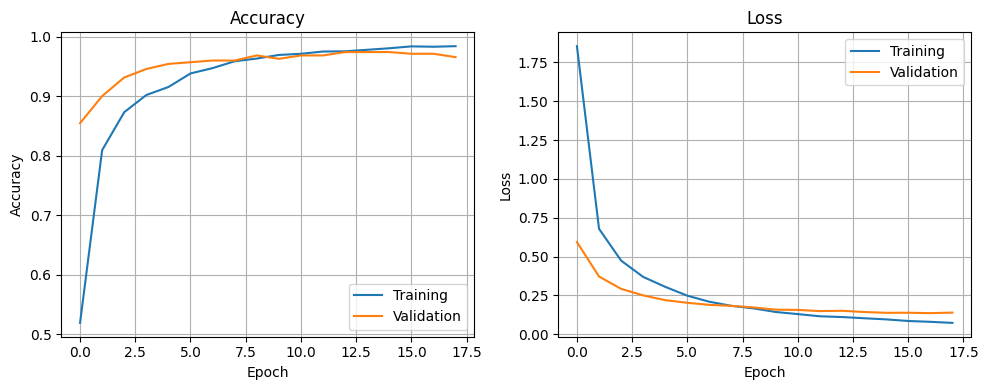

In [24]:
import matplotlib.pyplot as plt

# Extract training and validation metrics
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Accuracy
ax[0].plot(epochs, acc,     label='Training')
ax[0].plot(epochs, val_acc, label='Validation')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right')
ax[0].grid(True)

# Loss
ax[1].plot(epochs, loss,     label='Training')
ax[1].plot(epochs, val_loss, label='Validation')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right')
ax[1].grid(True)

plt.tight_layout()
plt.savefig('accuracyandloss.png', dpi=300, bbox_inches='tight')
plt.show()


In [27]:
model.load_weights("best_model.h5")

# Evaluate test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

 3/12 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9965 - loss: 0.0539

2025-07-02 22:13:17.449662: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/12 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9898 - loss: 0.0804

2025-07-02 22:13:22.057660: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9811 - loss: 0.1243
Test Accuracy: 0.9749
Test Loss: 0.1492


2025-07-01 20:39:07.978763: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-07-01 20:39:15.088138: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-07-01 20:39:40.821427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



                precision    recall  f1-score   support

        apple      0.889     0.800     0.842        10
       banana      1.000     0.778     0.875         9
     beetroot      1.000     1.000     1.000        10
  bell pepper      1.000     1.000     1.000        10
      cabbage      1.000     1.000     1.000        10
     capsicum      1.000     1.000     1.000        10
       carrot      1.000     0.900     0.947        10
  cauliflower      1.000     1.000     1.000        10
chilli pepper      0.909     1.000     0.952        10
         corn      0.900     0.900     0.900        10
     cucumber      1.000     1.000     1.000        10
     eggplant      1.000     1.000     1.000        10
       garlic      1.000     1.000     1.000        10
       ginger      0.909     1.000     0.952        10
       grapes      1.000     1.000     1.000        10
     jalepeno      1.000     1.000     1.000        10
         kiwi      1.000     1.000     1.000        10
       

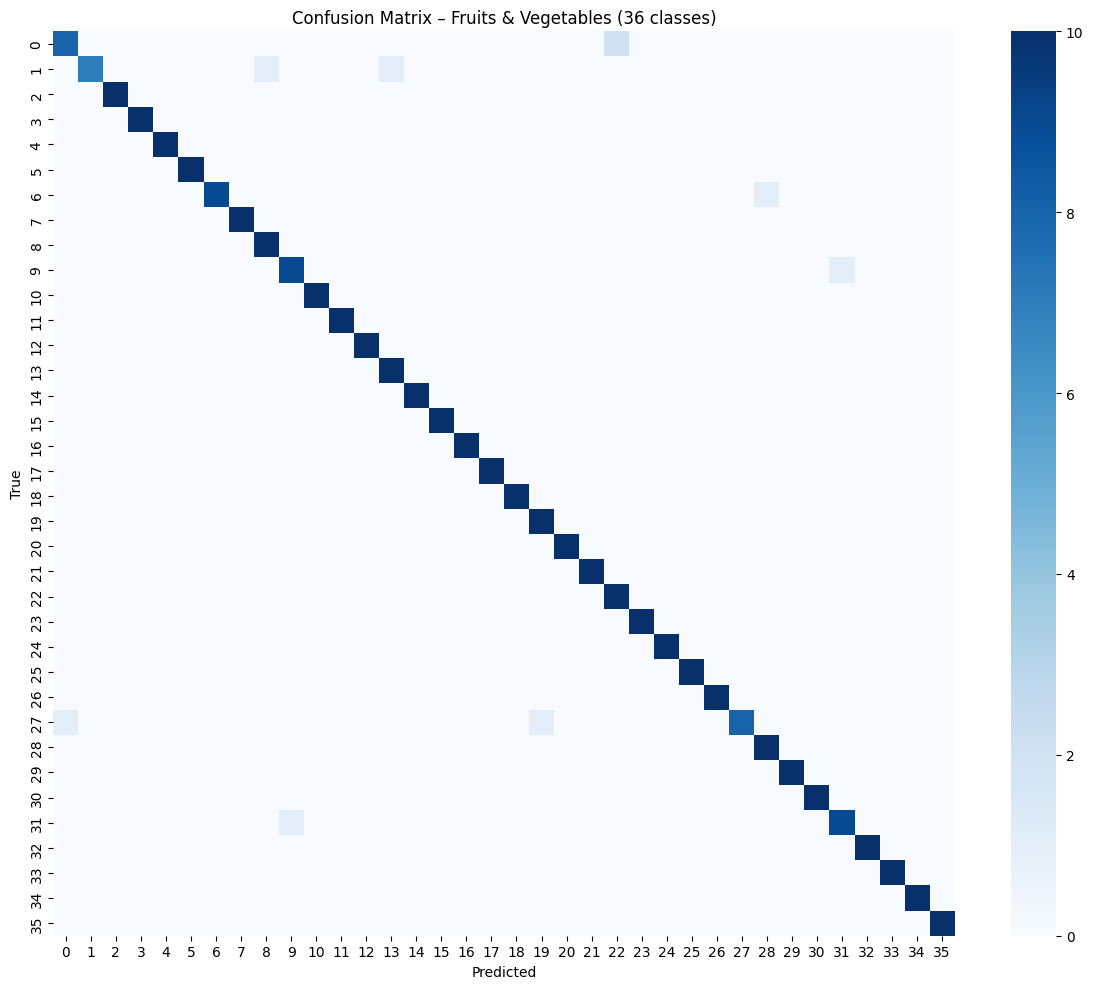

In [18]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true_list, y_pred_list = [], []

for images, true_labels in test_ds:          
    preds = model(images, training=False)   
    y_true_list.append(true_labels.numpy())
    y_pred_list.append(preds.numpy())

y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

y_true_labels = np.argmax(y_true, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)


# 2️⃣ classification report
print("\n", classification_report(
    y_true_labels, y_pred_labels, target_names=class_names, digits=3))

# 3️⃣ confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", cbar=True)
plt.title("Confusion Matrix – Fruits & Vegetables (36 classes)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix_fixed.png")   
plt.show()


2025-07-01 20:50:37.979758: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-07-01 20:50:38.276130: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-07-01 20:50:45.187943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


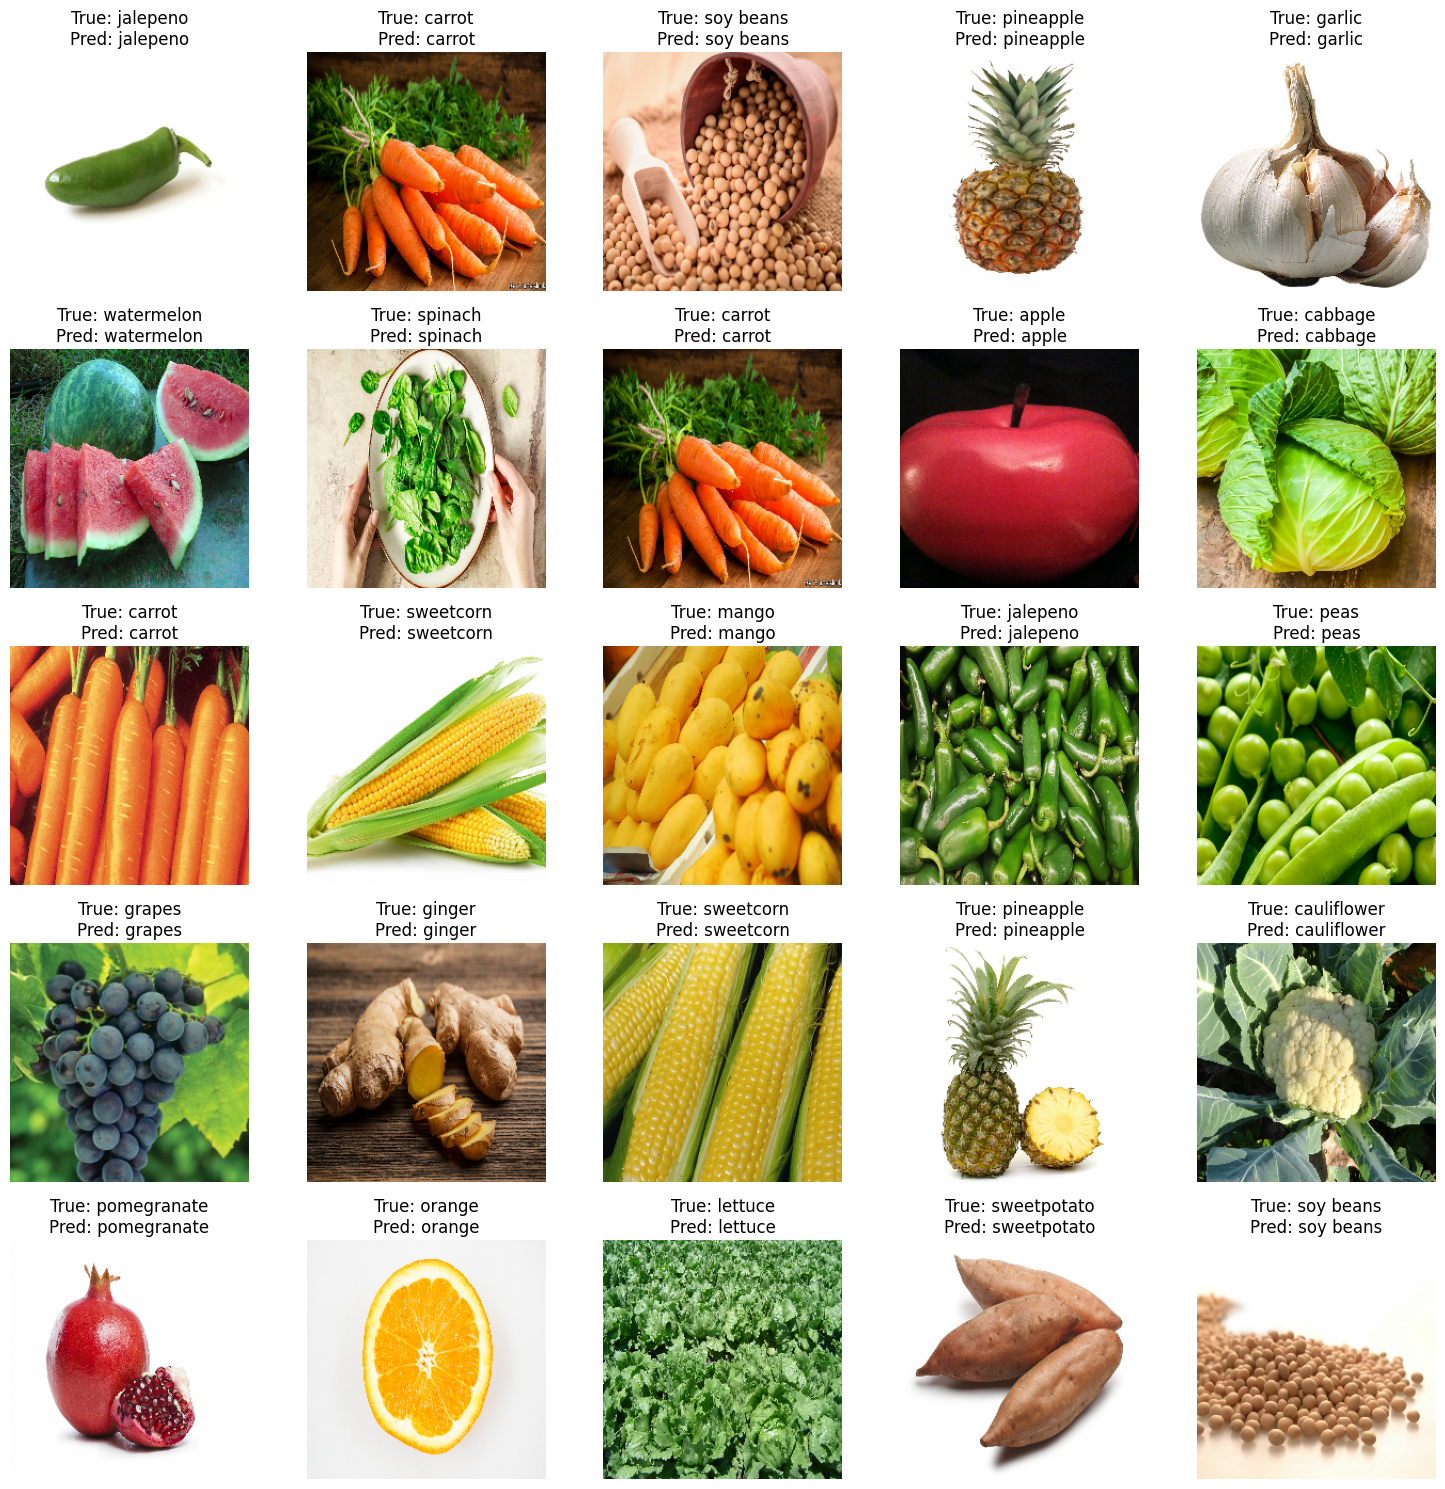

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 25 random test images (and get predictions)
sample_images = []
true_labels = []
pred_labels = []

for img_batch, label_batch in test_ds.unbatch().take(25):
    img = img_batch.numpy()
    label = np.argmax(label_batch.numpy())
    pred = np.argmax(model.predict(img[np.newaxis, ...], verbose=0))
    
    sample_images.append(img)
    true_labels.append(class_names[label])
    pred_labels.append(class_names[pred])

# Plot
plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow((sample_images[i] + 1) / 2)  # unnormalize [-1, 1] → [0, 1]
    plt.title(f"True: {true_labels[i]}\nPred: {pred_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.savefig("random_predictions.png")
plt.show()


2025-07-01 20:51:09.270834: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-07-01 20:51:11.948160: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-07-01 20:52:11.847733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


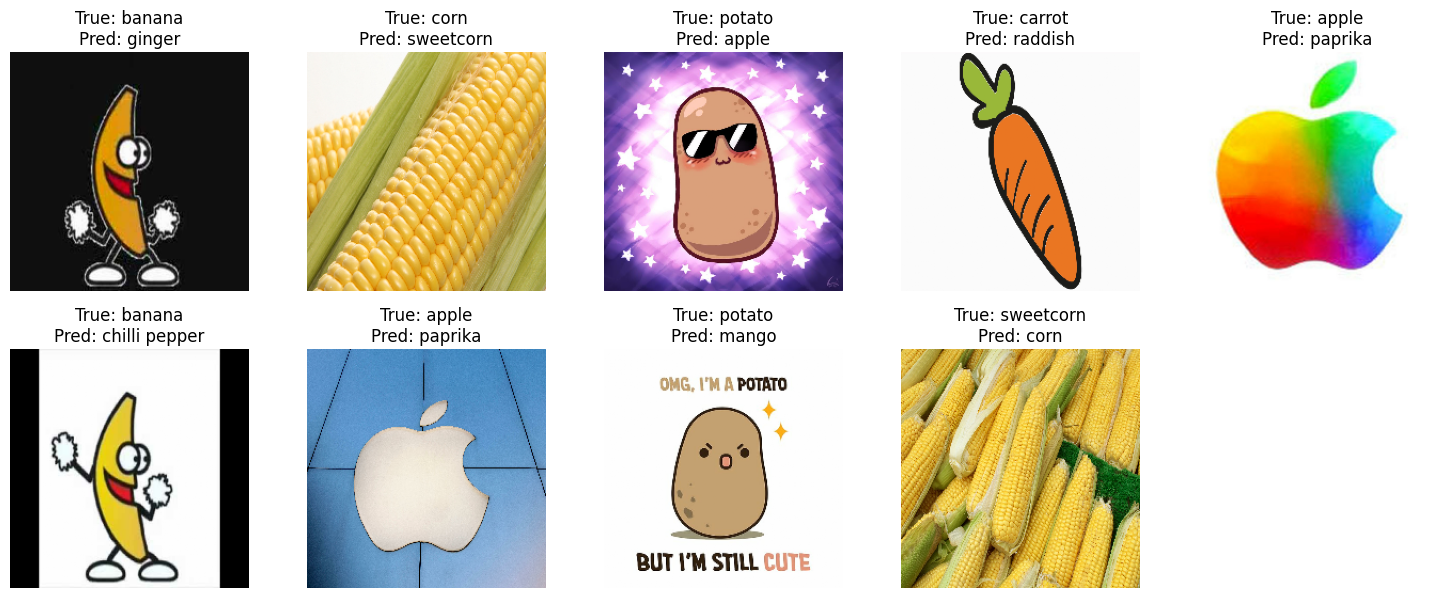

In [20]:
misclassified = []

for img_batch, label_batch in test_ds.unbatch():
    img = img_batch.numpy()
    true = np.argmax(label_batch.numpy())
    pred = np.argmax(model.predict(img[np.newaxis, ...], verbose=0))
    if true != pred:
        misclassified.append((img, true, pred))
    if len(misclassified) == 25:
        break

if misclassified:
    plt.figure(figsize=(15, 15))
    for i, (img, true, pred) in enumerate(misclassified):
        plt.subplot(5, 5, i + 1)
        plt.imshow((img + 1) / 2)  # unnormalize
        plt.title(f"True: {class_names[true]}\nPred: {class_names[pred]}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig("misclassified_predictions.png")
    plt.show()
else:
    print("✅ No misclassified images found in first 359 test samples!")
